In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
from clr.clr_callback import CyclicLR

In [2]:
#reading dataset
df = pd.read_csv('Train.csv')  
#val_df = pd.read_excel('val.xlsx')
test_df = pd.read_csv('Val.csv')

In [3]:
train_df=df.sample(frac = 0.25)

print('size of training set: %s' % (len(train_df['Utterance'])))
print('size of validation set: %s' % (len(test_df ['Utterance'])))


train_df.head(10)

size of training set: 3775
size of validation set: 3100


,Utterance,Intent
504,is new this a good insurance plan for me,5
6690,what do you get when you roll a dice with five...,66
7268,place call to robby,72
5392,are you sure i don???t think that???s correct,53
7731,i need to know the due date for my credit card,77
11584,tell me how many vacation days i have,115
6945,set a reminder to go dress shopping,69
13774,i no longer need the reservation for 20 at ihop,137
2374,how can i change my oil in my car,23
11376,what paperwork will i need to visit northern i...,113


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3775 entries, 504 to 8676
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Utterance  3775 non-null   object
 1   Intent     3775 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 88.5+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3100 entries, 0 to 3099
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Utterance  3100 non-null   object
 1   Intent     3100 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.6+ KB


In [6]:
train_df['Intent'].value_counts()

145    48
148    33
117    32
43     32
22     32
       ..
51     18
102    17
25     17
8      17
24     13
Name: Intent, Length: 150, dtype: int64

In [7]:
test_df['Intent'].value_counts()

150    100
145     40
103     20
96      20
97      20
      ... 
50      20
51      20
52      20
53      20
75      20
Name: Intent, Length: 150, dtype: int64

### **Data Preparation**

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
train_df["Utterance"].iloc[0]

'is new this a good insurance plan for me'

In [10]:
test_df["Utterance"].iloc[0]

'in spanish, meet me tomorrow is said how'

In [11]:
token = tokenizer.encode_plus(
    train_df['Utterance'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

In [12]:
token1 = tokenizer.encode_plus(
    test_df['Utterance'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

In [13]:
token.input_ids

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[ 101, 2003, 2047, 2023, 1037, 2204, 5427, 2933, 2005, 2033,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [14]:
token1.input_ids

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[ 101, 1999, 3009, 1010, 3113, 2033, 4826, 2003, 2056, 2129,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [15]:
X_input_ids = np.zeros((len(train_df), 256))
X_attn_masks = np.zeros((len(train_df), 256))

In [16]:
X_input_ids1 = np.zeros((len(test_df), 256))
X_attn_masks1 = np.zeros((len(test_df), 256))

In [17]:
X_input_ids.shape

(3775, 256)

In [18]:
X_input_ids1.shape

(3100, 256)

In [19]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(train_df['Utterance'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [20]:
def generate_test_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(test_df['Utterance'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [21]:
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [22]:
X_input_ids1, X_attn_masks1 = generate_test_data(df, X_input_ids1, X_attn_masks1, tokenizer)

0it [00:00, ?it/s]

In [23]:
labels = np.zeros((len(train_df), 151))
labels.shape

(3775, 151)

In [24]:
labels1 = np.zeros((len(test_df), 151))
labels1.shape

(3100, 151)

In [25]:
labels[np.arange(len(train_df)), train_df['Intent'].values] = 1 # one-hot encoded target tensor

In [26]:
labels1[np.arange(len(test_df)), test_df['Intent'].values] = 1 # one-hot encoded target tensor

In [27]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
labels1

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [29]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(151,), dtype=tf.float64, name=None))>

In [30]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset1 = tf.data.Dataset.from_tensor_slices((X_input_ids1, X_attn_masks1, labels1))
dataset1.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(151,), dtype=tf.float64, name=None))>

In [31]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [32]:
dataset = dataset.map(SentimentDatasetMapFunction) # converting to required format for tensorflow dataset 

In [33]:
dataset1 = dataset1.map(SentimentDatasetMapFunction) # converting to required format for tensorflow dataset 

In [34]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(151,), dtype=tf.float64, name=None))>

In [35]:
dataset1.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(151,), dtype=tf.float64, name=None))>

In [36]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [37]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 151), dtype=tf.float64, name=None))>

In [38]:
dataset1 = dataset1.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [39]:
dataset1.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 151), dtype=tf.float64, name=None))>

In [40]:
train_dataset = dataset
val_dataset = dataset1

### **Model**

In [41]:
from transformers import TFBertModel

In [42]:
model = TFBertModel.from_pretrained('bert-base-uncased') # bert base model with pretrained weights

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [43]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(151, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPooling(last_hidd               'attention_mask[0][0]']         
                                en_state=(None, 256                                               
                                , 768),                                                       

In [44]:
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [46]:
sentiment_model.compile(loss=loss_func, metrics=[acc])

In [47]:
clr = CyclicLR(base_lr=0.001, max_lr=2e-5,
                        step_size=2000., mode='exp_range',
                        gamma=0.99994)


In [48]:
hist = sentiment_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,callbacks=[clr]
)

Epoch 1/5
235/235 [==============================] - 5157s 22s/step - loss: 5.1111 - accuracy: 0.0088 - val_loss: 5.0157 - val_accuracy: 0.0126
Epoch 2/5
235/235 [==============================] - 5315s 23s/step - loss: 5.0200 - accuracy: 0.0117 - val_loss: 5.0144 - val_accuracy: 0.0130
Epoch 3/5
235/235 [==============================] - 5359s 23s/step - loss: 5.0112 - accuracy: 0.0128 - val_loss: 5.0136 - val_accuracy: 0.0130
Epoch 4/5
235/235 [==============================] - 5450s 23s/step - loss: 5.0090 - accuracy: 0.0128 - val_loss: 5.0131 - val_accuracy: 0.0126
Epoch 5/5
235/235 [==============================] - 5389s 23s/step - loss: 5.0074 - accuracy: 0.0128 - val_loss: 5.0128 - val_accuracy: 0.0130


In [49]:
sentiment_model.save('sentiment_model')

INFO:tensorflow:Assets written to: sentiment_model\assets


INFO:tensorflow:Assets written to: sentiment_model\assets


In [50]:
hist.history['accuracy']

[0.008776595816016197,
 0.011702127754688263,
 0.012765957042574883,
 0.012765957042574883,
 0.012765957042574883]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


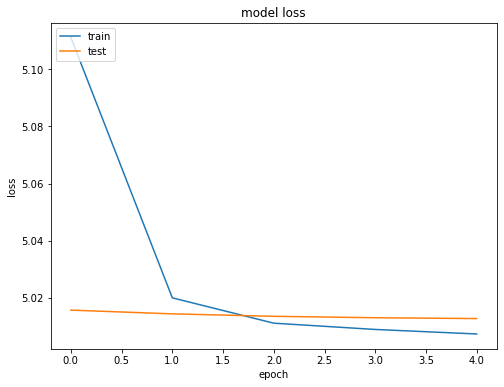

In [51]:
print(hist.history.keys())

import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

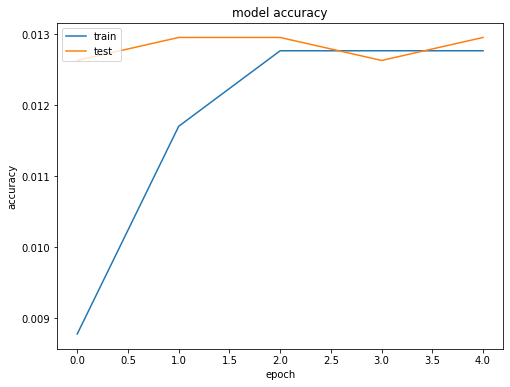

In [52]:
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()